In [34]:
import torch 

import torch.nn as nn 

import torch.nn.functional as F

import torchvision

import numpy as np

import matplotlib.pyplot as plt

from  torchvision import datasets, transforms

from torch.utils.data import DataLoader, Subset



Step 1: Filter CIFAR-10 for Dog vs Not-Dog

In [35]:
# Transform: Convert to tensor and normalize (grayscale optional)

transform = transforms.Compose([

    transforms.ToTensor(),

    transforms.Normalize((0.5),(0.5))
])

In [36]:
# Load Full CIFAR-10

train_set = torchvision.datasets.CIFAR10(root='.data', train=True, download='True',transform=transform)

test_set = torchvision.datasets.CIFAR10(root='.data', train=False, download='True',transform=transform)

In [37]:
# Label map

dog_class_index = train_set.class_to_idx['dog']

In [38]:
# Function to convert to binary Dog vs Not-Dog

def binary_target(dataset):

    binary_targets = torch.tensor([1 if label==dog_class_index else 0 for _,label in dataset])

    return binary_targets

In [39]:
# Create new datasets with binary labels

train_binary_targets = binary_target(train_set)

test_binary_targets = binary_target(test_set)

In [40]:
# Attach binary labels manually (hack for now)

train_set.targets = train_binary_targets.tolist()

test_set.targets = test_binary_targets.tolist()

In [41]:
# Wrap in DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print(" Binary Dog-vs-Not-Dog dataset is ready!")


 Binary Dog-vs-Not-Dog dataset is ready!


Step 2: CNN Architecture for Binary Classification

CNN Architecture

Two convolutional layers
Max pooling
ReLU activations
Fully connected output with sigmoid (for binary classification)
Conv(1 → 8) → ReLU → MaxPool
Conv(8 → 16) → ReLU → MaxPool
Flatten → FC(16×6×6 → 32) → ReLU → FC(32 → 2)

In [42]:
class DogCNN(nn.Module):

    def __init__(self):
        super(DogCNN,self).__init__()

        self.conv1 = nn.Conv2d(3, 16 , kernel_size=3, padding=1) 

        self.pool = nn.MaxPool2d(2,2) 

        self.conv2 = nn.Conv2d(16, 32 , kernel_size=3, padding=1)  


        self.fc1 = nn.Linear(32 * 8 * 8, 128)

        self.fc2 = nn.Linear(128, 1)  # Binary Output



    def forward(self,x):

        x = self.pool(F.relu(self.conv1(x))) # Conv1 + ReLU + Pool    # [B, 16, 16, 16]

        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pool   [B, 32, 8, 8]

        x = x.view(-1, 32 * 8 * 8)   # Flatten

        x = F.relu(self.fc1(x)) # FC1 + ReLU

        x = torch.sigmoid(self.fc2(x))  # Output between 0 and 1


        return x

Instantiate the Model

define the loss function and optimizer:

Step 3: Training Setup

In [43]:
model = DogCNN().to("mps")  # Use 'cuda' if on GPU or 'cpu'

criterion = nn.BCELoss()    # Because it's binary

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Step 4: Training Loop

In [44]:
epochs =5

for epoch in range(epochs):

    running_loss = 0.0

    correct, total = 0, 0


    for images, labels in train_loader:

        images, labels = images.to('mps'), labels.to('mps').float().unsqueeze(1)


        outputs = model(images)

        loss = criterion(outputs, labels)


        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        running_loss += loss.item()


        # Calculate accuracy

        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()

        total += labels.size(0)

    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {correct/total:.4f}")

Epoch [1/5], Loss: 197.6900, Accuracy: 0.9063
Epoch [2/5], Loss: 168.2146, Accuracy: 0.9162
Epoch [3/5], Loss: 157.5557, Accuracy: 0.9217
Epoch [4/5], Loss: 147.0576, Accuracy: 0.9273
Epoch [5/5], Loss: 138.0864, Accuracy: 0.9322


Step 5: Evaluate on the Test Set

In [45]:
model.eval()  # Switch to eval mode

correct = 0

total = 0


with torch.no_grad():

    for images, labels in test_loader:

        images, labels = images.to('mps'), labels.to('mps').float().unsqueeze(1)

        outputs = model(images)

        predicted = (outputs > 0.5).float()

        total += labels.size(0)

        correct += (predicted == labels).sum().item()

    
    print(f'Test Accuracy: {correct / total :.4f}')

Test Accuracy: 0.9278


Step 6: Visualize Predictions (Correct vs Incorrect)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
/var/folders/zr/xhd5gptd36zgdy5mmcv4gjfc0000gp/T/ipykernel_87862/881781090.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Prediction {classes[int(predicted[i])]} | Actual: {classes[int(labels[i])]}')


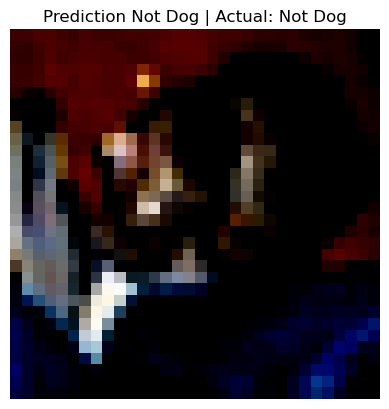

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


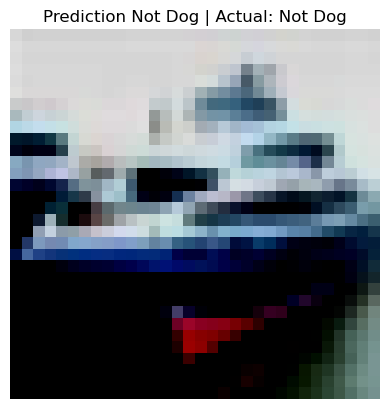

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].


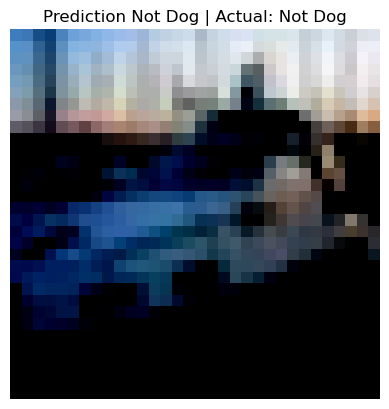

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].


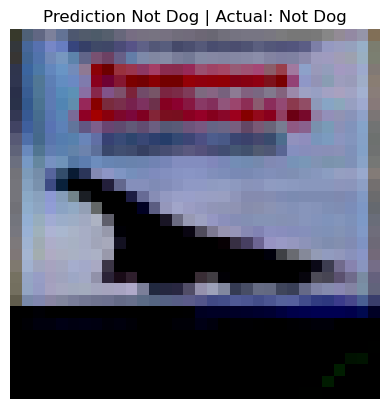

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


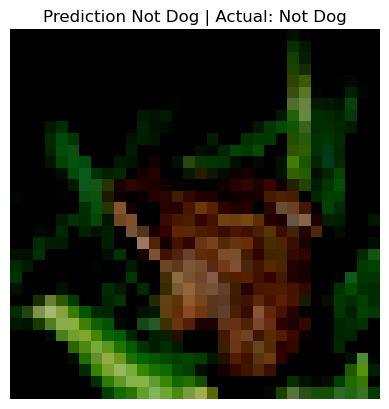

In [48]:
model.eval()

classes = ['Not Dog', 'Dog']

shown = 0


with torch.no_grad():

    for images, labels in test_loader:

        images = images.to('mps')

        outputs = model(images)

        predicted = (outputs > 0.5).float().cpu().numpy()



        for i in range(5):

            plt.imshow(images[i].permute(1,2,0).cpu())

            plt.title(f'Prediction {classes[int(predicted[i])]} | Actual: {classes[int(labels[i])]}')

            plt.axis('off')

            plt.show()

            shown += 1

            if shown >= 5:

                break

        if shown >= 5:

                break

Step 7: Visualize Learned Filters (Optional, but Powerful)

To peek into what features the CNN has learned:

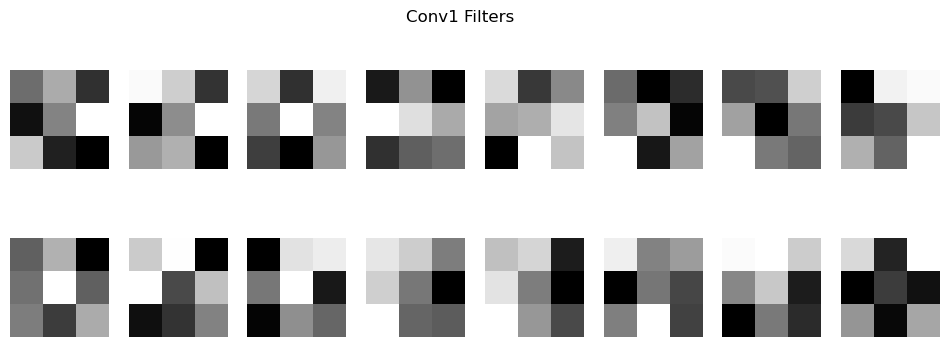

In [51]:
# Visualize filters of the first conv layer

filters = model.conv1.weight.data.cpu()


fig, axs = plt.subplots(2,8, figsize=(12,4))

for i in range(16):

    ax = axs[i // 8, i % 8]

    ax.imshow(filters[i][0], cmap='gray')

    ax.axis('off')

plt.suptitle('Conv1 Filters')

plt.show()